In [1]:
%matplotlib inline

import glob
from string import letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import signal
from sklearn.decomposition import PCA

import scipy.stats

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


"Differential_expression_carcass" are all genes with no NA's in the differential expression analysis for carcass.  
This file was created in 20160123_IR_Analysis.ipynb

"Differential_expression_testes" are all genes with no NA's in the differential expression analysis for testes.  
This file was created in 20160123_IR_Analysis.ipynb

Here, we're just going to focus on carcass.

In [2]:
gene_transcripts=pd.read_csv("/Users/leandraking/Desktop/Junk_folder_so_my_desktop_looks_clean/SacktonProject/Differential_expression_carcass")
gene_transcripts.head()

#all_genes_transcripts = open("/Users/leandraking/Desktop/Junk_folder_so_my_desktop_looks_clean/SacktonProject/all_gene_transcripts_carcass","w")
#for ele in list(gene_transcripts.iloc[:,0].values):
#    all_genes_transcripts.write(ele +'\n')
#all_genes_transcripts.close()


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,FBtr0071764,15.313548,-0.596308,0.876222,2.933125,0.402051,0.999990
1,FBtr0100521,138.134037,-0.040438,0.726202,2.436115,0.486947,0.999990
2,FBtr0071763,65.232033,0.395227,1.558861,0.797560,0.850051,0.999990
3,FBtr0342981,6.738338,-8.243602,3.801850,4.284990,0.232289,0.884288
4,FBtr0083388,43.318354,0.626185,0.522643,4.918860,0.177836,0.803411


In [4]:
len(gene_transcripts)

23980

In [6]:
len(gene_transcripts[gene_transcripts.padj<.05]) #The 463 differentially epxress

463

We first convert these gene transcripts to gene names.  We get the conversion table by uploading all_gene_names carcass here: http://flybase.org/static_pages/downloads/IDConv.html There are fewer unique ids.

In [12]:
gene_names_to_transcripts_table = pd.read_table("FlyBase_IDs-carcass_complete_cases_conversion_table.txt")
gene_names_to_transcripts_table.head()
gene_names_to_transcripts_table.columns = [u'transcript_name', u'current_id', u'converted_id', u'current_symbol']

Some transcripts are not associated with a gene

In [13]:
gene_names_to_transcripts_table[gene_names_to_transcripts_table.converted_id=="-"]

,transcript_name,current_id,converted_id,current_symbol
779,FBtr0110845,unknown ID,-,-
2331,FBtr0333694,unknown ID,-,-
3205,FBtr0305187,unknown ID,-,-
3899,FBtr0306251,unknown ID,-,-
6357,FBtr0345349,unknown ID,-,-
6681,FBtr0344728,unknown ID,-,-
8434,FBtr0305188,unknown ID,-,-
8455,FBtr0302988,unknown ID,-,-
10623,FBtr0074106,unknown ID,-,-
11992,FBtr0300131,unknown ID,-,-


also more than one transcript sometimes correspond to a single gene location

In [9]:
#Why is this 11756 instead of 11755? Because  equal to '-' when unknown id
len(gene_names_to_transcripts_table.converted_id.unique())

11756

In [7]:
#Sackton question: do I have to convert these gene names to new versions?

We now need to enter these gene names into flybase (flybase.org > batch downloads > fastA file) in order to get the location of these genes.

In [10]:
all_genes_diff_expression_analysis_after_fastA = []
all_gene_locations_diff_expression_analysis=[]
fp=open("FlyBase_FastA_all_genes_carcass.txt", "r")
for line in fp:
    if line[0]=='>':
        all_gene_locations_diff_expression_analysis.append(line.split(";")[1])
        all_genes_diff_expression_analysis_after_fastA.append(line.split(";")[0].split(' ')[0][1:])
fp.close()
print "len(all_gene_locations_diff_expression_analysis):", len(all_gene_locations_diff_expression_analysis)
all_gene_locations_diff_expression_analysis[:10]
#loc = pd.DataFrame([all_genes_diff_expression_analysis_after_fastA,all_gene_locations_diff_expression_analysis])
#loc.head()

len(all_gene_locations_diff_expression_analysis): 11755


[' loc=X:19961297..19969323',
 ' loc=X:20051294..20052519',
 ' loc=X:20133579..20138878',
 ' loc=X:complement(20000968..20002096)',
 ' loc=X:complement(19958393..19959403)',
 ' loc=3L:23126025..23132209',
 ' loc=3L:complement(23147656..23150499)',
 ' loc=3L:complement(23093190..23095471)',
 ' loc=X:245978..254650',
 ' loc=X:255674..258469']

In [9]:
#Now check why 11755 instead of 11756 - because presence of '-'
#k = list(gene_names_to_transcripts_table.converted_id.apply(str))
#print [a for a in k if a not in all_genes_diff_expression_analysis_after_fastA]


['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']


In [25]:
all_gene_locations_diff_expression_analysis =[ele.replace('complement(','') for ele in all_gene_locations_diff_expression_analysis]
all_gene_locations_diff_expression_analysis = [ele.strip(')') for ele in all_gene_locations_diff_expression_analysis]

diff_expression_df=pd.DataFrame()
diff_expression_df["chr"]=[ele.split(":")[0].split("=")[1] for ele in all_gene_locations_diff_expression_analysis]
diff_expression_df["start"]=[ele.split(":")[1].split("..")[0] for ele in all_gene_locations_diff_expression_analysis]
diff_expression_df["end"]=[ele.split("..")[1] for ele in all_gene_locations_diff_expression_analysis]


diff_expression_df.to_csv("All_genes_carcass_df")

diff_expression_df['converted_id'] = [str(ele) for ele in all_genes_diff_expression_analysis_after_fastA]
diff_expression_df.head()

,chr,start,end,converted_id
0,X,19961297,19969323,FBgn0031081
1,X,20051294,20052519,FBgn0031085
2,X,20133579,20138878,FBgn0031088
3,X,20000968,20002096,FBgn0031082
4,X,19958393,19959403,FBgn0031080


Now we want to join binding pval information to this table.  

In [14]:
gene_names_to_transcripts_table.head()

,transcript_name,current_id,converted_id,current_symbol
0,FBtr0335289,FBtr0335289,FBgn0033051,Strica
1,FBtr0074312,FBtr0074312,FBgn0010412,RpS19a
2,FBtr0347575,FBtr0347575,FBgn0038839,Ktl
3,FBtr0347418,FBtr0347418,FBgn0023083,fray
4,FBtr0071563,FBtr0071563,FBgn0016984,sktl


In [15]:
gene_transcripts.columns = [u'transcript_name', u'baseMean', u'log2FoldChange', u'lfcSE', u'stat',
       u'pvalue', u'padj']
gene_transcripts.head()

,transcript_name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,FBtr0071764,15.313548,-0.596308,0.876222,2.933125,0.402051,0.999990
1,FBtr0100521,138.134037,-0.040438,0.726202,2.436115,0.486947,0.999990
2,FBtr0071763,65.232033,0.395227,1.558861,0.797560,0.850051,0.999990
3,FBtr0342981,6.738338,-8.243602,3.801850,4.284990,0.232289,0.884288
4,FBtr0083388,43.318354,0.626185,0.522643,4.918860,0.177836,0.803411


Now we need to merge the two previous tables
Note: here we do an inner merge! This may not be ideal because multiple transcripts for a given gene -- which is actually okay cause inner won't delete these

In [27]:
merged = gene_names_to_transcripts_table.merge(gene_transcripts, on="transcript_name") # now also merge location
merged.head()



,transcript_name,current_id,converted_id,current_symbol,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,FBtr0335289,FBtr0335289,FBgn0033051,Strica,24.367633,0.380476,1.409681,0.710788,0.870664,0.999990
1,FBtr0074312,FBtr0074312,FBgn0010412,RpS19a,17.278816,-0.557089,1.235144,0.643886,0.886316,0.999990
2,FBtr0347575,FBtr0347575,FBgn0038839,Ktl,39.412949,-0.606636,1.419979,0.245831,0.969872,0.999990
3,FBtr0347418,FBtr0347418,FBgn0023083,fray,54.310397,-1.181607,1.113361,1.385973,0.708826,0.999990
4,FBtr0071563,FBtr0071563,FBgn0016984,sktl,226.898267,-0.574422,0.310924,4.098292,0.251044,0.904181


In [28]:
#Now we want to add differential expression data

merged = merged.merge(diff_expression_df, on ="converted_id")
#merged = gene_names_to_transcripts_table.merge(diff_expression_df, on="transcript_name")
merged.head()




,transcript_name,current_id,converted_id,current_symbol,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr,start,end
0,FBtr0335289,FBtr0335289,FBgn0033051,Strica,24.367633,0.380476,1.409681,0.710788,0.870664,0.999990,2R,6020311,6023144
1,FBtr0086028,FBtr0086028,FBgn0033051,Strica,68.683677,0.337959,0.554159,3.456290,0.326476,0.973658,2R,6020311,6023144
2,FBtr0074312,FBtr0074312,FBgn0010412,RpS19a,17.278816,-0.557089,1.235144,0.643886,0.886316,0.999990,X,16637894,16639249
3,FBtr0340149,FBtr0340149,FBgn0010412,RpS19a,21.368757,-0.288886,0.718981,0.820723,0.844504,0.999990,X,16637894,16639249
4,FBtr0074311,FBtr0074311,FBgn0010412,RpS19a,2840.350899,0.047333,0.113781,3.427310,0.330313,0.977452,X,16637894,16639249


In [29]:
diff_expression_df = merged[["transcript_name", "converted_id", "pvalue", "padj","chr", "start", "end"]]
diff_expression_df.head()



,transcript_name,converted_id,pvalue,padj,chr,start,end
0,FBtr0335289,FBgn0033051,0.870664,0.999990,2R,6020311,6023144
1,FBtr0086028,FBgn0033051,0.326476,0.973658,2R,6020311,6023144
2,FBtr0074312,FBgn0010412,0.886316,0.999990,X,16637894,16639249
3,FBtr0340149,FBgn0010412,0.844504,0.999990,X,16637894,16639249
4,FBtr0074311,FBgn0010412,0.330313,0.977452,X,16637894,16639249


In [30]:
diff_expression_df.groupby("chr").count()

,transcript_name,converted_id,pvalue,padj,start,end
chr,,,,,,
211000022280328,1,1,1,1,1,1
2L,4412,4412,4412,4412,4412,4412
2R,4846,4846,4846,4846,4846,4846
3L,4551,4551,4551,4551,4551,4551
3R,5768,5768,5768,5768,5768,5768
4,269,269,269,269,269,269
Unmapped_Scaffold_8_D1580_D1567,2,2,2,2,2,2
X,4105,4105,4105,4105,4105,4105
Y,7,7,7,7,7,7


We remove info from non-main chromos

In [31]:
diff_expression_df=diff_expression_df.loc[diff_expression_df["chr"].isin(["X", "2L","2R","3L","3R","4"])]
diff_expression_df.groupby("chr").count()

,transcript_name,converted_id,pvalue,padj,start,end
chr,,,,,,
2L,4412,4412,4412,4412,4412,4412
2R,4846,4846,4846,4846,4846,4846
3L,4551,4551,4551,4551,4551,4551
3R,5768,5768,5768,5768,5768,5768
4,269,269,269,269,269,269
X,4105,4105,4105,4105,4105,4105


In [32]:
diff_expression_df = diff_expression_df.dropna()
diff_expression_df.groupby("chr").count()

,transcript_name,converted_id,pvalue,padj,start,end
chr,,,,,,
2L,4412,4412,4412,4412,4412,4412
2R,4846,4846,4846,4846,4846,4846
3L,4551,4551,4551,4551,4551,4551
3R,5768,5768,5768,5768,5768,5768
4,269,269,269,269,269,269
X,4105,4105,4105,4105,4105,4105


In [36]:
#Just checking out differentially expressed genes -- seems like we lost one? unclear why
print len(diff_expression_df[diff_expression_df.padj<.05])
diff_expression_df[diff_expression_df.padj<.05].head()

462


,transcript_name,converted_id,pvalue,padj,chr,start,end
58,FBtr0343798,FBgn0086778,0.000236,0.019465,X,19327075,19348447
95,FBtr0082158,FBgn0002868,0.000007,0.001336,3R,9783407,9784370
243,FBtr0078312,FBgn0053056,0.000013,0.002069,3L,21198261,21203232
345,FBtr0335410,FBgn0267435,0.000004,0.000758,3R,31204180,31210730
487,FBtr0075908,FBgn0015904,0.000096,0.010157,3L,12580672,12596018


Now we turn to the BAM data (differential binding).  The location of each row in this data is in the locations_df, which was created here: http://localhost:8888/notebooks/20160308CleaningData.ipynb

In [37]:
locations_df=pd.read_csv("Locations",sep=',')
locations_df.columns = ["erase", "chr", "start", "end"]
locations_df = locations_df[["chr", "start", "end"]]
print len(locations_df)
locations_df.head()

388464


,chr,start,end
0,211000022278049,390,394
1,211000022278049,537,541
2,211000022278049,573,577
3,211000022278049,837,841
4,211000022278049,1613,1617


We first need to append the binding pvals to the location df.  pval and padj datasets capture the loci where there is differential binding (ie we did a lrt test between full model: protein + line + line:protein, and reduced model: protein + line

In [38]:
lpadj=[]
lpval=[]
for f1 in glob.glob("nbin*"):
    df_padj = pd.read_csv(f1).padj
    df_pval = pd.read_csv(f1).pvalue
    lpadj.append(df_padj)
    lpval.append(df_pval)
pval = pd.concat(lpval, axis = 1)
padj = pd.concat(lpadj, axis = 1)

pval.columns= map(lambda x: x[25:], glob.glob("nbin*"))
pval.columns = ['C_D1_pval', 'C_Lam_pval', 'T_D1_pval', 'T_Lam_pval', 'W_D1_pval', 'W_Lam_pval']
pval = pval[['C_D1_pval', 'C_Lam_pval', 'W_D1_pval', 'W_Lam_pval']]
pval.head()

padj.columns= map(lambda x: x[25:], glob.glob("nbin*"))
padj.columns = ['C_D1_padj', 'C_Lam_padj', 'T_D1_padj', 'T_Lam_padj', 'W_D1_padj', 'W_Lam_padj']
padj = padj[['C_D1_padj', 'C_Lam_padj', 'W_D1_padj', 'W_Lam_padj']]
padj.head()

,C_D1_padj,C_Lam_padj,W_D1_padj,W_Lam_padj
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN


In [39]:
padj.columns.values

array(['C_D1_padj', 'C_Lam_padj', 'W_D1_padj', 'W_Lam_padj'], dtype=object)

In [40]:
print len(pval)

388464


In [41]:
diff_binding_df = pd.concat([locations_df, padj, pval], axis=1)
diff_binding_df.head()

,chr,start,end,C_D1_padj,C_Lam_padj,W_D1_padj,W_Lam_padj,C_D1_pval,C_Lam_pval,W_D1_pval,W_Lam_pval
0,211000022278049,390,394,NaN,NaN,NaN,NaN,0.485389,0.830966,0.765493,0.755112
1,211000022278049,537,541,NaN,NaN,NaN,NaN,0.932556,0.963826,0.523501,0.710687
2,211000022278049,573,577,NaN,NaN,NaN,NaN,0.887479,0.929716,0.523501,0.471454
3,211000022278049,837,841,NaN,NaN,NaN,NaN,0.318436,0.107370,0.331726,0.642423
4,211000022278049,1613,1617,NaN,NaN,NaN,NaN,0.828294,0.477111,0.626573,0.350185


Then remove all non-main chromos

In [42]:
diff_binding_df=diff_binding_df.loc[diff_binding_df["chr"].isin(["X", "2L","2R","3L","3R","4"])]
diff_binding_df.groupby("chr").count()

,start,end,C_D1_padj,C_Lam_padj,W_D1_padj,W_Lam_padj,C_D1_pval,C_Lam_pval,W_D1_pval,W_Lam_pval
chr,,,,,,,,,,
2L,62455,62455,11726,47847,23027,8605,62455,62259,62455,62455
2R,73744,73744,13692,52047,26250,9209,73739,73578,73743,73744
3L,78641,78641,14007,57949,27367,9834,78637,78415,78641,78641
3R,87864,87864,16486,63486,31330,10854,87858,87704,87864,87863
4,3578,3578,869,2589,2148,331,3578,3575,3578,3578
X,67353,67353,7653,40513,14196,2877,67353,67230,67353,67353


In [43]:
diff_binding_df.head()

,chr,start,end,C_D1_padj,C_Lam_padj,W_D1_padj,W_Lam_padj,C_D1_pval,C_Lam_pval,W_D1_pval,W_Lam_pval
773,2L,11272191,11272195,0.700650,0.108932,NaN,NaN,0.394513,0.023049,0.645497,0.924707
774,2L,15990781,15990785,NaN,NaN,NaN,NaN,0.854032,0.127611,0.784685,0.755179
775,2L,589823,589827,NaN,NaN,NaN,NaN,0.860739,0.502502,0.885395,0.909439
776,2L,1130493,1130497,NaN,0.150547,NaN,NaN,0.097152,0.040183,0.809064,0.521929
777,2L,10797055,10797059,0.763605,0.600310,1,0.999842,0.492147,0.424928,0.906563,0.458070


Now we need to merge the differential binding dataset and the differential expression dataset by location! (BAM data and diff expression data in order to correlate p-vals)

In [60]:
diff_expression_df[diff_expression_df.padj<.05].shape

(462, 7)

In [96]:
#sort expression df
diff_expression_df.sort_values(by=["chr", "start"], inplace=True)
diff_expression_df.reset_index(drop=True, inplace=True)
diff_expression_df.head(n=10)

#sort binding df
diff_binding_df.sort_values(by=["chr", "start"], inplace=True)
diff_binding_df.reset_index(drop=True, inplace=True)
diff_binding_df.head(n=10)

,chr,start,end,C_D1_padj,C_Lam_padj,W_D1_padj,W_Lam_padj,C_D1_pval,C_Lam_pval,W_D1_pval,W_Lam_pval,index_of_merged
0,2L,79,83,NaN,NaN,NaN,NaN,0.103948,0.025274,0.408745,0.998241,NaN
1,2L,228,232,NaN,0.076184,1,NaN,0.191722,0.012271,0.463676,0.846525,NaN
2,2L,369,373,NaN,0.117092,1,NaN,0.930541,0.026064,0.666317,0.574588,NaN
3,2L,537,541,NaN,0.131953,1,NaN,0.953649,0.032043,0.689684,0.273858,NaN
4,2L,686,690,NaN,0.188088,1,NaN,0.704137,0.058906,0.446207,0.117429,NaN
5,2L,827,831,NaN,0.101184,1,NaN,0.198650,0.020234,0.692421,0.314087,NaN
6,2L,995,999,NaN,0.175111,1,NaN,0.195360,0.052085,0.622848,0.311790,NaN
7,2L,1144,1148,NaN,0.129421,1,NaN,0.556157,0.030997,0.666159,0.533622,NaN
8,2L,1285,1289,NaN,0.029390,1,NaN,0.697879,0.002278,0.817167,0.364797,NaN
9,2L,1453,1457,NaN,0.018332,1,NaN,0.654028,0.000975,0.828183,0.647541,NaN


In [69]:
key = 0
for chromo in ["X", "2L","2R","3L","3R","4"]:
    print chromo
    diff_expression1 = diff_expression_df[diff_expression_df.chr == chromo]
    diff_binding1 = diff_binding_df[diff_binding_df.chr == chromo]

    for i, row1 in diff_expression1.iterrows():
        print i,
        for j, row2 in diff_binding1.iterrows():
            #Doing the 5kb thing
            if (float(row1['end'])+5000) >= float(row2['end']) and (float(row1['start']) - 5000) <= float(row2['start']) :               
                diff_binding_df.ix[j, 'index_of_merged'] = key
                diff_expression_df.ix[i, 'index_of_merged'] = key
                key +=1
                break
            '''elif float(row1['end']) <= float(row2['end']) and float(row1['start']) >= float(row2['start']) :
                diff_binding_df.ix[j, 'index_of_merged'] = i
                diff_expression_df.ix[i, 'index_of_merged'] = j
                print i, j, 'b'
                break'''
    

 X
2 3 4 5 55 56 57 58 94 109 113 114 115 116 117 118 175 176 178 179 210 211 218 222 223 240 241 242 283 284 285 286 287 288 289 290 291 292 310 311 312 313 314 315 316 317 328 341 349 350 358 359 360 376 377 378 380 381 382 383 405 406 407 418 419 420 421 466 467 468 469 489 490 491 492 493 494 495 496 497 498 499 500 501 523 547 548 549 550 551 579 580 600 601 602 603 604 605 606 607 608 623 624 625 626 627 628 629 630 631 632 643 644 645 649 650 673 674 691 692 711 712 713 714 720 721 722 723 724 725 726 727 769 770 771 772 780 781 782 800 801 802 812 827 828 829 830 831 834 835 871 872 873 900 901 902 903 904 906 907 908 909 910 911 912 913 914 915 916 917 940 945 946 947 949 950 951 952 953 987 988 989 990 991 992 993 998 999 1000 1001 1011 1012 1013 1014 1016 1017 1023 1024 1052 1053 1074 1075 1082 1098 1099 1100 1101 1102 1103 1104 1105 1128 1129 1130 1136 1155 1156 1157 1158 1203 1204 1205 1206 1207 1208 1209 1210 1211 1212 1213 1214 1224 1251 1252 1253 1266 1281 1282 1308 130

KeyboardInterrupt: 

In [39]:
diff_expression_df.head()

,transcript_name,converted_id,pvalue,padj,chr,start,end,index_of_merged
0,FBtr0335289,FBgn0033051,0.870664,0.999990,2R,6020311,6023144,8474
1,FBtr0086028,FBgn0033051,0.326476,0.973658,2R,6020311,6023144,8475
2,FBtr0074312,FBgn0010412,0.886316,0.999990,X,16637894,16639249,0
3,FBtr0340149,FBgn0010412,0.844504,0.999990,X,16637894,16639249,1
4,FBtr0074311,FBgn0010412,0.330313,0.977452,X,16637894,16639249,2


In [40]:
a= pd.merge(diff_binding_df[np.isfinite(diff_binding_df['index_of_merged'])], diff_expression_df[np.isfinite(diff_expression_df['index_of_merged'])], on="index_of_merged")

In [42]:
#a.to_csv("20161121_table_for_correlation")
a.to_csv("20170701_table_for_correlation_plus_minus_5kb")

In [44]:
a = pd.read_csv("20161121_table_for_correlation")

In [59]:
len(a), len(a[a.padj<.05])

(10545, 229)

In [44]:
a.tail(n=20)

,chr_x,start_x,end_x,C_D1_padj,C_Lam_padj,W_D1_padj,W_Lam_padj,C_D1_pval,C_Lam_pval,W_D1_pval,W_Lam_pval,index_of_merged,transcript_name,converted_id,pvalue,padj,chr_y,start_y,end_y
10525,X,22542542,22542546,NaN,NaN,NaN,NaN,0.205020,0.731215,0.316384,0.939536,3780,FBtr0077363,FBgn0031196,0.815795,0.999990,X,22542386,22544322
10526,X,22584465,22584469,NaN,0.913407,NaN,NaN,0.477650,0.859757,0.540072,0.197402,3162,FBtr0077362,FBgn0052499,0.312521,0.961332,X,22583634,22632710
10527,X,22809552,22809556,NaN,0.086428,NaN,NaN,0.165458,0.015274,0.385397,0.899732,4012,FBtr0077343,FBgn0031201,0.005923,0.144305,X,22809292,22811935
10528,X,22824590,22824594,NaN,0.482272,NaN,NaN,0.322419,0.293930,0.334334,0.841312,1276,FBtr0333179,FBgn0000719,0.976233,0.999990,X,22824317,22855194
10529,X,22832418,22832422,NaN,0.756495,NaN,NaN,0.894048,0.627010,0.826137,0.459361,1247,FBtr0333178,FBgn0259677,0.559849,0.999990,X,22832399,22885541
10530,X,22873102,22873106,NaN,0.205078,NaN,NaN,0.637333,0.068183,0.299476,0.174659,1735,FBtr0112536,FBgn0263829,0.345597,0.996538,X,22872812,22875367
10531,X,22945496,22945500,NaN,0.702649,NaN,NaN,0.137828,0.554107,0.951804,0.420624,4054,FBtr0111194,FBgn0069938,0.100065,0.629309,X,22945321,22946339
10532,X,22959368,22959372,NaN,0.056428,NaN,NaN,0.478185,0.007206,0.188145,0.587015,3580,FBtr0343092,FBgn0263830,0.775218,0.999990,X,22958856,22960091
10533,X,22980958,22980962,NaN,0.255548,NaN,NaN,0.060780,0.099553,0.282922,0.643261,2153,FBtr0302021,FBgn0016975,0.847350,0.999990,X,22980722,23004648
10534,X,23009010,23009014,NaN,NaN,NaN,NaN,0.613165,0.128142,0.749221,0.512849,1587,FBtr0299926,FBgn0044872,0.018606,0.276263,X,23008766,23011303


In [46]:
a["C_Lam_pval_logged"] = np.log10(a["C_Lam_pval"])
a["pvalue_logged"] = np.log10(a["pvalue"])

array([[ 1.        , -0.01349574],
       [-0.01349574,  1.        ]])

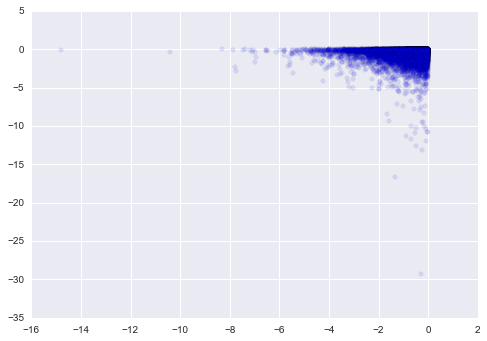

In [47]:
plt.scatter(a[np.isfinite(a['C_Lam_pval'])].C_Lam_pval_logged,a[np.isfinite(a['C_Lam_pval'])].pvalue_logged, alpha=.1)
np.corrcoef(a[np.isfinite(a['C_Lam_pval'])].C_Lam_pval_logged, a[np.isfinite(a['C_Lam_pval'])].pvalue_logged)

array([[ 1.        , -0.00412542],
       [-0.00412542,  1.        ]])

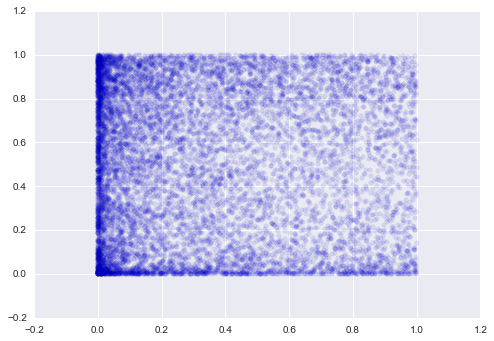

In [48]:
conditions=(np.isfinite(a['C_Lam_pval'])) & (a.C_Lam_pval!=1) & (a.pvalue!=1)

plt.scatter(a[conditions].C_Lam_pval,a[conditions].pvalue, alpha=.1)
np.corrcoef(a[conditions].C_Lam_pval, a[conditions].pvalue)

array([[ 1.        ,  0.00656099],
       [ 0.00656099,  1.        ]])

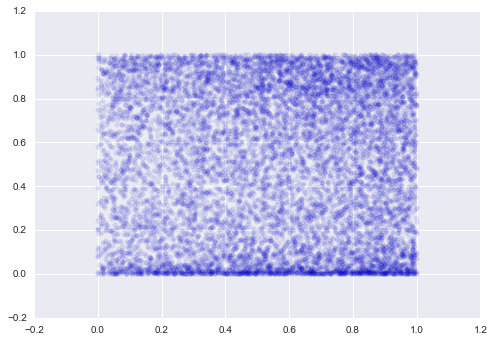

In [49]:
conditions=(np.isfinite(a['W_Lam_pval']))

plt.scatter(a[conditions].W_Lam_pval,a[conditions].pvalue, alpha=.1)
np.corrcoef(a[conditions].W_Lam_pval, a[conditions].pvalue)

array([[ 1.        ,  0.00393685],
       [ 0.00393685,  1.        ]])

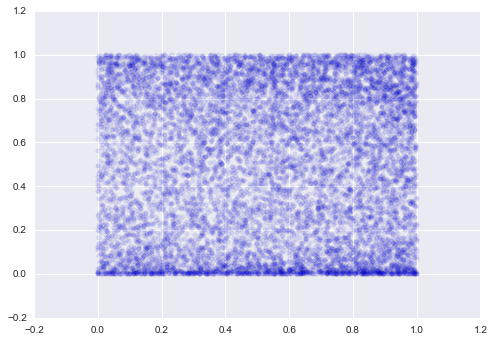

In [54]:
plt.scatter(a[np.isfinite(a['W_D1_pval'])].W_D1_pval,a[np.isfinite(a['W_D1_pval'])].pvalue, alpha=.1)
np.corrcoef(a[np.isfinite(a['W_D1_pval'])].W_D1_pval, a[np.isfinite(a['W_D1_pval'])].pvalue)

array([[ 1.        , -0.03712237],
       [-0.03712237,  1.        ]])

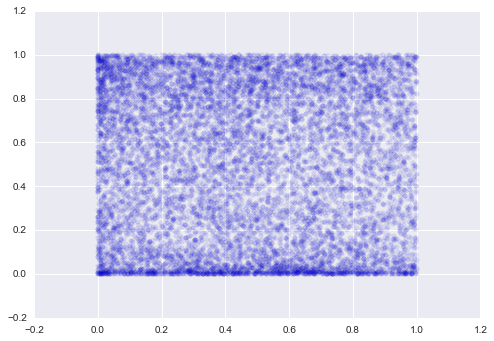

In [51]:
plt.scatter(a[np.isfinite(a['C_D1_pval'])].C_D1_pval,a[np.isfinite(a['C_D1_pval'])].pvalue, alpha=.1)
np.corrcoef(a[np.isfinite(a['C_D1_pval'])].C_D1_pval, a[np.isfinite(a['C_D1_pval'])].pvalue)

We don't see any correlation.  However, we are interested in determining whether there is a difference in the binding of Lam and D1 for differentially bound and non-differentially bound genes

In [58]:
#plt.hist(a[np.isfinite(a['C_D1_pval'])][a.padj<.05].C_D1_pval)
a[a.padj<.05].shape ##I guess we only have binding information at 229 differentially expressed sites?  
#Can check by running the long code on the 463 differentially expressed sites.

(229, 22)

(array([ 23.,  31.,  19.,  30.,  21.,  20.,  16.,  24.,  24.,  21.]),
 array([  5.43496015e-04,   1.00185910e-01,   1.99828324e-01,
          2.99470738e-01,   3.99113152e-01,   4.98755566e-01,
          5.98397980e-01,   6.98040394e-01,   7.97682808e-01,
          8.97325222e-01,   9.96967636e-01]),
 <a list of 10 Patch objects>)

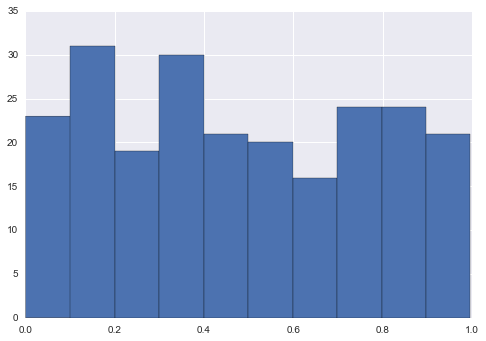

In [67]:
plt.hist(a[a.padj<.05].C_D1_pval.values)
#plt.hist(a[a.padj>.05].C_D1_pval.values)

In [42]:
#diff_binding_df.to_csv("20161117_diff_binding_df_for_merged")

In [43]:
#diff_expression_df.to_csv("2016117_diff_expression_df_for_merged")

In [12]:
diff_binding_df = pd.read_csv("20161117_diff_binding_df_for_merged")
diff_binding_df.head()

,Unnamed: 0,chr,start,end,C_D1,C_Lam,T_D1,T_Lam,W_D1,W_Lam,C_D1.1,C_Lam.1,T_D1.1,T_Lam.1,W_D1.1,W_Lam.1,index_of_merged
0,773,2L,11272191,11272195,0.700650,0.108932,NaN,0.896229,NaN,NaN,0.394513,0.023049,0.888672,0.818333,0.645497,0.924707,11960
1,774,2L,15990781,15990785,NaN,NaN,NaN,NaN,NaN,NaN,0.854032,0.127611,0.866477,0.762729,0.784685,0.755179,NaN
2,775,2L,589823,589827,NaN,NaN,NaN,NaN,NaN,NaN,0.860739,0.502502,0.494482,0.220448,0.885395,0.909439,NaN
3,776,2L,1130493,1130497,NaN,0.150547,NaN,NaN,NaN,NaN,0.097152,0.040183,0.703430,0.788780,0.809064,0.521929,16264
4,777,2L,10797055,10797059,0.763605,0.600310,NaN,0.739909,1,0.999842,0.492147,0.424928,0.974624,0.573217,0.906563,0.458070,14924


In [13]:
diff_expression_df = pd.read_csv("2016117_diff_expression_df_for_merged")
diff_expression_df.head()

,Unnamed: 0,transcript_name,converted_id,pvalue,padj,chr,start,end,index_of_merged
0,0,FBtr0335289,FBgn0033051,0.870664,0.999990,2R,6020311,6023144,81704
1,1,FBtr0086028,FBgn0033051,0.326476,0.973658,2R,6020311,6023144,81704
2,2,FBtr0074312,FBgn0010412,0.886316,0.999990,X,16637894,16639249,356536
3,3,FBtr0340149,FBgn0010412,0.844504,0.999990,X,16637894,16639249,356536
4,4,FBtr0074311,FBgn0010412,0.330313,0.977452,X,16637894,16639249,356536


In [34]:
diff_binding_df[diff_binding_df.chr =="2R"].loc[81704,]

Unnamed: 0            82477
chr                      2R
start               6287375
end                 6287379
C_D1                    NaN
C_Lam                   NaN
T_D1                    NaN
T_Lam                   NaN
W_D1                    NaN
W_Lam                   NaN
C_D1.1             0.507041
C_Lam.1            0.568905
T_D1.1             0.719063
T_Lam.1            0.849005
W_D1.1             0.671545
W_Lam.1            0.173408
index_of_merged         NaN
key1                  81704
key2                    NaN
Name: 81704, dtype: object

In [14]:
diff_binding_df["key1"] = diff_binding_df.index
diff_expression_df["key1"] = diff_expression_df.index_of_merged

diff_binding_df["key2"] = diff_binding_df.index_of_merged
diff_expression_df["key2"] = diff_expression_df.index

In [21]:
result = pd.merge(diff_binding_df, diff_expression_df, how='left', on=['key1'])

In [22]:
result.head()

,Unnamed: 0_x,chr_x,start_x,end_x,C_D1,C_Lam,T_D1,T_Lam,W_D1,W_Lam,...,Unnamed: 0_y,transcript_name,converted_id,pvalue,padj,chr_y,start_y,end_y,index_of_merged_y,key2_y
0,773,2L,11272191,11272195,0.70065,0.108932,NaN,0.896229,NaN,NaN,...,47047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,23951
1,773,2L,11272191,11272195,0.70065,0.108932,NaN,0.896229,NaN,NaN,...,47048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,23952
2,773,2L,11272191,11272195,0.70065,0.108932,NaN,0.896229,NaN,NaN,...,47049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,23953
3,773,2L,11272191,11272195,0.70065,0.108932,NaN,0.896229,NaN,NaN,...,47050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,23954
4,773,2L,11272191,11272195,0.70065,0.108932,NaN,0.896229,NaN,NaN,...,47051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,23955


In [29]:
diff_expression_df[diff_expression_df.chr =="2L"].loc[16264,]

Unnamed: 0               16269
transcript_name    FBtr0333098
converted_id       FBgn0032223
pvalue                0.857543
padj                   0.99999
chr                         2L
start              1.03337e+07
end                1.03392e+07
index_of_merged          29747
key1                     29747
key2                     16264
Name: 16264, dtype: object

In [31]:
diff_binding_df[diff_binding_df.chr=="2L"].loc[29747,]

Unnamed: 0            30520
chr                      2L
start              10571078
end                10571082
C_D1                    NaN
C_Lam                   NaN
T_D1                    NaN
T_Lam                   NaN
W_D1                    NaN
W_Lam                   NaN
C_D1.1             0.574994
C_Lam.1            0.691311
T_D1.1             0.931673
T_Lam.1            0.687997
W_D1.1             0.903939
W_Lam.1            0.346373
index_of_merged       14333
key1                  29747
key2                  14333
Name: 29747, dtype: object

In [9]:
a = pd.merge(diff_binding_df, diff_expression_df, how = "left", on = "key")

In [10]:
a.head()

,Unnamed: 0_x,chr_x,start_x,end_x,C_D1,C_Lam,T_D1,T_Lam,W_D1,W_Lam,...,key,Unnamed: 0_y,transcript_name,converted_id,pvalue,padj,chr_y,start_y,end_y,index_of_merged_y
0,773,2L,11272191,11272195,0.70065,0.108932,NaN,0.896229,NaN,NaN,...,0,47047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,773,2L,11272191,11272195,0.70065,0.108932,NaN,0.896229,NaN,NaN,...,0,47048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,773,2L,11272191,11272195,0.70065,0.108932,NaN,0.896229,NaN,NaN,...,0,47049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,773,2L,11272191,11272195,0.70065,0.108932,NaN,0.896229,NaN,NaN,...,0,47050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,773,2L,11272191,11272195,0.70065,0.108932,NaN,0.896229,NaN,NaN,...,0,47051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [63]:
diff_binding1[np.isfinite(diff_binding1['index_of_merged'])]

,chr,start,end,C_D1,C_Lam,T_D1,T_Lam,W_D1,W_Lam,C_D1,C_Lam,T_D1,T_Lam,W_D1,W_Lam,index_of_merged
304222,4,819199,819203,NaN,NaN,NaN,NaN,NaN,NaN,0.23247,0.607558,0.382255,0.992859,0.71606,0.712288,2783


In [56]:
diff_expression1[diff_expression1.index_of_merged !=0]

,transcript_name,converted_id,pvalue,padj,chr,start,end,index_of_merged
370,FBtr0089147,FBgn0039890,0.948673,0.999990,4,184076,193829,NaN
371,FBtr0089150,FBgn0039890,0.516808,0.999990,4,184076,193829,304267
372,FBtr0089146,FBgn0039890,0.714519,0.999990,4,184076,193829,NaN
373,FBtr0308247,FBgn0039890,0.763492,0.999990,4,184076,193829,NaN
374,FBtr0089149,FBgn0039890,0.005758,0.141899,4,184076,193829,NaN
375,FBtr0089148,FBgn0039890,0.563552,0.999990,4,184076,193829,NaN
422,FBtr0333701,FBgn0039927,0.328077,0.974879,4,1126602,1137919,NaN
423,FBtr0089195,FBgn0039927,0.285979,0.937093,4,1126602,1137919,NaN
424,FBtr0089194,FBgn0039927,0.087708,0.595482,4,1126602,1137919,NaN
581,FBtr0089125,FBgn0039904,0.931905,0.999990,4,359938,375554,NaN


In [31]:
diff_expression1 = diff_expression_df[diff_expression_df.chr == "4"][:100]
diff_expression1["index_of_merged"]=[0 for ele in diff_expression1['chr']]
diff_expression1

,transcript_name,converted_id,pvalue,padj,chr,start,end,index_of_merged
370,FBtr0089147,FBgn0039890,0.948673,0.999990,4,184076,193829,0
371,FBtr0089150,FBgn0039890,0.516808,0.999990,4,184076,193829,0
372,FBtr0089146,FBgn0039890,0.714519,0.999990,4,184076,193829,0
373,FBtr0308247,FBgn0039890,0.763492,0.999990,4,184076,193829,0
374,FBtr0089149,FBgn0039890,0.005758,0.141899,4,184076,193829,0
375,FBtr0089148,FBgn0039890,0.563552,0.999990,4,184076,193829,0
422,FBtr0333701,FBgn0039927,0.328077,0.974879,4,1126602,1137919,0
423,FBtr0089195,FBgn0039927,0.285979,0.937093,4,1126602,1137919,0
424,FBtr0089194,FBgn0039927,0.087708,0.595482,4,1126602,1137919,0
581,FBtr0089125,FBgn0039904,0.931905,0.999990,4,359938,375554,0


In [ ]:
for i,row1 in enumerate(merged.iterrows()):
    print i,
    key = str(row1[1]['chr'])     
    subset_chrom_df=locations_df[locations_df.chr == key]
    len_subset_chrom_df = subset_chrom_df.shape[0]
    for j in range(len_subset_chrom_df):
        try:
            if float(row1[1]['end']) >= float(subset_chrom_df.loc[subset_chrom_df.index[j],'end']) and float(row1[1]['start']) <= float(subset_chrom_df.loc[subset_chrom_df.index[j],'start']) :
                #print list(row1[1]), subset_chrom_df.index[j]
                
                locations_df.ix[subset_chrom_df.index[j], 'contains_diff_expressed']=str(list(row1[1]))
                    #diff_expression_df.ix[i,'chromatin_state'] = subset_chrom_df.ix[subset_chrom_df.index[j],'chromatin']
        except:
            pass

In [ ]:
locations_df["contains_diff_expressed"]=[0 for ele in locations_df['chr']]
for i,row1 in enumerate(diff_expression_df.iterrows()):
    print i,
    key = str(row1[1]['chr'])     
    subset_chrom_df=locations_df[locations_df.chr == key]
    len_subset_chrom_df = subset_chrom_df.shape[0]
    for j in range(len_subset_chrom_df):
        try:
            if float(row1[1]['end']) >= float(subset_chrom_df.loc[subset_chrom_df.index[j],'end']) and float(row1[1]['start']) <= float(subset_chrom_df.loc[subset_chrom_df.index[j],'start']) :
                #print list(row1[1]), subset_chrom_df.index[j]
                
                locations_df.ix[subset_chrom_df.index[j], 'contains_diff_expressed']=str(list(row1[1]))
                    #diff_expression_df.ix[i,'chromatin_state'] = subset_chrom_df.ix[subset_chrom_df.index[j],'chromatin']
        except:
            pass

locations_df that gives us the regions that are differentially bound.
diff_expression_df gives differentially expressed genes for carcass (it was created in 20160731_Including_heterochromatic_state.ipynb) 

The first step is to find which rows of the locations df correspond to differentially bound regions. We do this in 20160731_Correlating_diff_expression_and_diff_binding.  We load the dataset in the following line.


In [ ]:
locations_df=pd.read_csv("locations_df_with_diff_expressed",sep=';')
locations_df.head()

In [ ]:
locations_df["contains_diff_expressed"]=[0 for ele in locations_df['chr']]
for i,row1 in enumerate(diff_expression_df.iterrows()):
    print i,
    key = str(row1[1]['chr'])     
    subset_chrom_df=locations_df[locations_df.chr == key]
    len_subset_chrom_df = subset_chrom_df.shape[0]
    for j in range(len_subset_chrom_df):
        try:
            if float(row1[1]['end']) >= float(subset_chrom_df.loc[subset_chrom_df.index[j],'end']) and float(row1[1]['start']) <= float(subset_chrom_df.loc[subset_chrom_df.index[j],'start']) :
                #print list(row1[1]), subset_chrom_df.index[j]
                
                locations_df.ix[subset_chrom_df.index[j], 'contains_diff_expressed']=str(list(row1[1]))
                    #diff_expression_df.ix[i,'chromatin_state'] = subset_chrom_df.ix[subset_chrom_df.index[j],'chromatin']
        except:
            pass

In [ ]:

locations_df[locations_df.contains_diff_expressed!='0'].groupby("chr").count()

Restricting locations to avoid various scaffolding chromos

In [ ]:
locations_df_restricted=locations_df[locations_df["chr"].isin(["X", "2L","2R","3L","3R","4"])]